# Performance analysis at system-level


## Reproduce line chart for CPU utiliztion


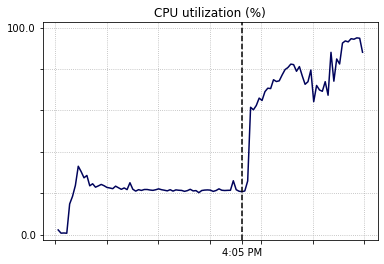

In [1]:
import py2neo
import pandas as pd
import matplotlib.pyplot as plt

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password = 'neo4j')

# query for CPU measurements
cpu_query = """
MATCH (r:Record)-[:CONTAINS]->(c:CpuUtilization)
WHERE r.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN c.timestamp AS timestamp, c.cpuID AS cpuID, c.totalUtilization * 100 AS cpuUtilization
ORDER BY timestamp
"""
df = pd.DataFrame(graph.run(cpu_query).data())
# drop first and last measurements to sanitize data
df.drop(df.head(3).index, inplace=True)
df.drop(df.tail(5).index, inplace=True)

# cast to datetime and round up to the nearest second
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.round('1s')
df['CPU ID'] = pd.to_numeric(df['cpuID'])
# get the mean utilization of every CPU core
df = df.groupby(['timestamp']).mean()
df = df.drop('CPU ID', 1)

# get the average of 7 measurements to sanitize the data
df_cpu_plot = df.rolling(7).mean()
df_cpu_plot = df_cpu_plot.iloc[::7, :]

# label and style the plot
plt.plot_date(df_cpu_plot.index, df_cpu_plot['cpuUtilization'], fmt='-', color='#00035b')
plt.title('CPU utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

# fill in the data
date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
# As we don't know the time zone, we choose the time that makes the most sense
plt.xticks(date_list + ['2015-08-20 08:05'], ['', '', '', '', '', '', '', '4:05 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 08:05', color='black', label='4:05 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# uncomment to save the plot as a pdf
# plt.savefig('cpu_plot.pdf')
plt.show()

## Reproduce line chart for memory utilization


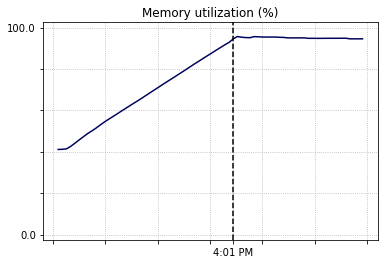

In [2]:
# query for memory measurements
mem_query = """
MATCH (r:Record)-[:CONTAINS]->(m:MemSwapUsage)
WHERE r.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN m.timestamp AS timestamp, toFloat(m.memUsed)*100.0 / toFloat(m.memTotal) AS memoryUtilization
ORDER BY timestamp
"""
df_mem = pd.DataFrame(graph.run(mem_query).data())
# drop first and last measurements to sanitize data
df_mem.drop(df_mem.head(3).index, inplace=True)
df_mem.drop(df_mem.tail(5).index, inplace=True)

# cast to datetime and round up to the nearest second
df_mem['timestamp'] = pd.to_datetime(df_mem['timestamp'])
df_mem['timestamp'] = df_mem['timestamp'].dt.round('1s')
df_mem.set_index('timestamp', inplace=True)

# get the average of 10 measurements to sanitize the data
df_mem_plot = df_mem.rolling(10).mean()
df_mem_plot = df_mem_plot.iloc[::10, :]

# label and style the plot
plt.plot_date(df_mem_plot.index, df_mem_plot['memoryUtilization'], fmt='-', color='#00035b')
plt.title('Memory utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

# fill in the data
date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
plt.xticks(date_list + ['2015-08-20 08:01'], ['', '', '', '', '', '', '', '4:01 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 08:01', color='black', label='4:01 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# uncomment to save the plot as a pdf
# plt.savefig('mem_plot.pdf')
plt.show()